This notebook presents the final model selection and evaluation process. The performance of various machine learning models is compared using key metrics such as accuracy, precision, recall, and F1 score. The notebook concludes with the selection of the best-performing model for predicting hotel booking cancellations.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Directory to save the best model
model_save_path = 'best_model.pth'

# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Data Preprocessing 

In [3]:
# Load the dataset
file_path = "../data/cleaned.csv"
df = pd.read_csv(file_path)

# Define features and target
X = df.drop(columns=['is_canceled'])
y = df['is_canceled']

# List of categorical columns including numerical categories
categorical_columns = [
    'hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
    'distribution_channel', 'reserved_room_type', 'assigned_room_type',
    'deposit_type', 'customer_type', 'arrival_date_year',
    'arrival_date_week_number', 'arrival_date_day_of_month',
    'company', 'agent'
]

# List of true numerical columns
numerical_columns = [
    'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
    'adults', 'children', 'babies', 'is_repeated_guest',
    'previous_cancellations', 'previous_bookings_not_canceled',
    'booking_changes', 'days_in_waiting_list', 'adr',
    'required_car_parking_spaces', 'total_of_special_requests'
]


# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_columns)
    ]
)


# Fit the preprocessor on the entire dataset to capture all categories
preprocessor.fit(X)

# Split the dataset into training (70%), incremental (10%), and testing (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_incremental, y_test, y_incremental = train_test_split(X_temp, y_temp, test_size=0.6666, random_state=42, stratify=y_temp)

# Save the preprocessor
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

# Apply the preprocessor to the training and test sets
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)




In [4]:
# Save the splits after preprocessing except for the incremental set
train_data = (X_train_resampled, y_train_resampled)
incremental_data = (X_incremental, y_incremental)
test_data = (X_test, y_test)

with open('train_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)

with open('incremental_data.pkl', 'wb') as f:
    pickle.dump(incremental_data, f)

with open('test_data.pkl', 'wb') as f:
    pickle.dump(test_data, f)

# Defining The Model

In [5]:
# Function to create the model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_layer_sizes, dropout):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        prev_size = input_dim
        for size in hidden_layer_sizes:
            self.layers.append(nn.Linear(prev_size, size))
            self.layers.append(nn.LeakyReLU())
            self.layers.append(nn.Dropout(dropout))
            prev_size = size
      
        self.output = nn.Linear(prev_size, 1)


    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = torch.sigmoid(self.output(x))
        return x


# Function to train the model
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        running_loss += loss.item()
    return running_loss / len(train_loader)

# Function to validate the model
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = outputs.round()
            correct += preds.eq(labels).sum().item()
    accuracy = correct / len(val_loader.dataset)
    return running_loss / len(val_loader), accuracy


In [6]:
# Best parameters from the grid search
best_params = ((1024, 512, 256), 0.3, 0.001, 64)

# Retraining with the best parameters
hidden_layer_sizes, dropout, learning_rate, batch_size = best_params
print(f"Retraining with best params: {hidden_layer_sizes}, {dropout}, {learning_rate}, {batch_size}")

# Define Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5)

fold_accuracies = []
val_accuracies = []
train_losses = []
for fold, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
    print(f"Fold {fold + 1}/{skf.n_splits}")
    X_train_fold, X_val_fold = X_train_resampled[train_index], X_train_resampled[val_index]
    y_train_fold, y_val_fold = y_train_resampled[train_index], y_train_resampled[val_index]

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_fold.values, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_fold.values, dtype=torch.float32).view(-1, 1)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss function, and optimizer
    input_dim = X_train_tensor.shape[1]
    model = NeuralNetwork(input_dim, hidden_layer_sizes, dropout).to(device)
    criterion = nn.BCELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) 
    # Using a cyclic learning rate scheduler
    scheduler = CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=2000, mode='triangular2')

    # Training loop
    num_epochs = 200
    patience = 30
    patience_counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(model, val_loader, criterion, device)
        print(f" Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        scheduler.step(val_loss)  # Step the scheduler

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), model_save_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(" Early stopping triggered")
                break

        val_accuracies.append(val_accuracy)
        train_losses.append(train_loss)

    fold_accuracies.append(val_accuracy)

# Calculate mean fold accuracy
mean_fold_accuracy = np.mean(fold_accuracies)
print(f"Mean fold accuracy for best params {hidden_layer_sizes}, {dropout}, {learning_rate}, {batch_size}: {mean_fold_accuracy}")


Retraining with best params: (1024, 512, 256), 0.3, 0.001, 64
Fold 1/5
 Epoch 1/200, Train Loss: 0.5392, Val Loss: 0.4069, Val Accuracy: 0.8061
 Epoch 2/200, Train Loss: 0.3805, Val Loss: 0.3735, Val Accuracy: 0.8211
 Epoch 3/200, Train Loss: 0.3561, Val Loss: 0.3582, Val Accuracy: 0.8294
 Epoch 4/200, Train Loss: 0.3420, Val Loss: 0.3478, Val Accuracy: 0.8347
 Epoch 5/200, Train Loss: 0.3308, Val Loss: 0.3386, Val Accuracy: 0.8392
 Epoch 6/200, Train Loss: 0.3210, Val Loss: 0.3310, Val Accuracy: 0.8409
 Epoch 7/200, Train Loss: 0.3123, Val Loss: 0.3254, Val Accuracy: 0.8432
 Epoch 8/200, Train Loss: 0.3057, Val Loss: 0.3199, Val Accuracy: 0.8456
 Epoch 9/200, Train Loss: 0.2991, Val Loss: 0.3154, Val Accuracy: 0.8494
 Epoch 10/200, Train Loss: 0.2933, Val Loss: 0.3120, Val Accuracy: 0.8533
 Epoch 11/200, Train Loss: 0.2880, Val Loss: 0.3087, Val Accuracy: 0.8539
 Epoch 12/200, Train Loss: 0.2839, Val Loss: 0.3061, Val Accuracy: 0.8554
 Epoch 13/200, Train Loss: 0.2790, Val Loss: 0.304

In [7]:
# Loading the best model
best_model = NeuralNetwork(input_dim, best_params[0], best_params[1]).to(device)
best_model.load_state_dict(torch.load(model_save_path))
best_model.eval()

print("Best model loaded with parameters:", best_params)

# Total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

# Total number of trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of trainable parameters: {total_trainable_params}')

# Model architecture
print(model)




Best model loaded with parameters: ((1024, 512, 256), 0.3, 0.001, 64)
Total number of parameters: 1692673
Total number of trainable parameters: 1692673
NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=1011, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.3, inplace=False)
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


# Evaluuate Model:

Test Loss: 0.3283, Test Accuracy: 0.8830
Accuracy: 0.8830081232727577
Precision: 0.8384787472035794
Recall: 0.8473886502373954
F1 Score: 0.8429101540537501

Confusion Matrix:
[[6796  722]
 [ 675 3748]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91      7518
         1.0       0.84      0.85      0.84      4423

    accuracy                           0.88     11941
   macro avg       0.87      0.88      0.87     11941
weighted avg       0.88      0.88      0.88     11941



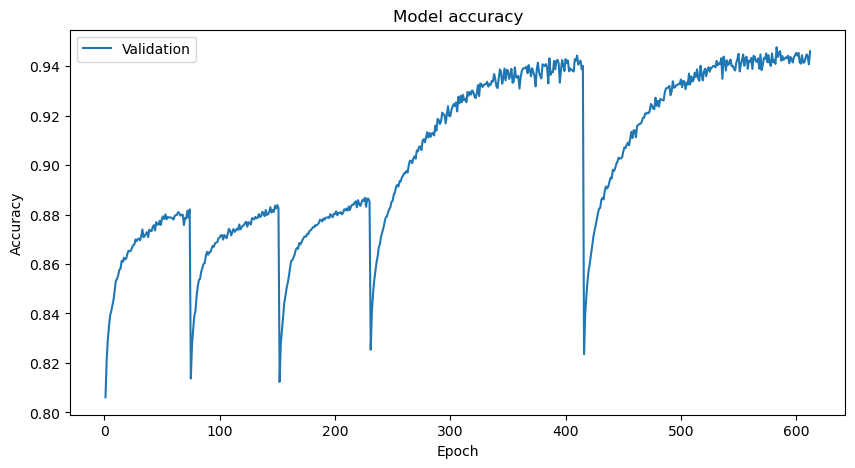

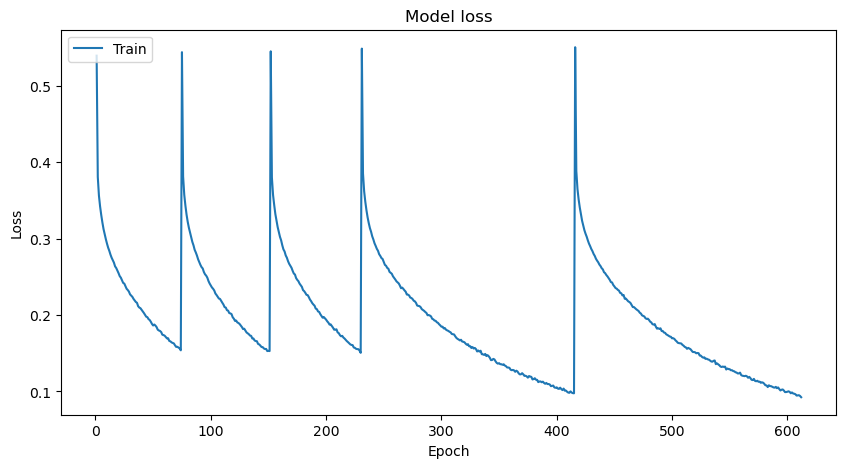

In [8]:
# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test_preprocessed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create DataLoader for the test set
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the function to evaluate the model on the test set
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = outputs.round()
            correct += preds.eq(labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    accuracy = correct / len(test_loader.dataset)
    return running_loss / len(test_loader), accuracy, all_labels, all_preds

# Function to evaluate the model
def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
    }

# Evaluate the best model on the test set
test_loss, test_accuracy, all_labels, all_preds = evaluate(best_model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Use the evaluate_model function to print and get evaluation metrics
metrics = evaluate_model(all_labels, all_preds)

# Plotting validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Confusion Matrix

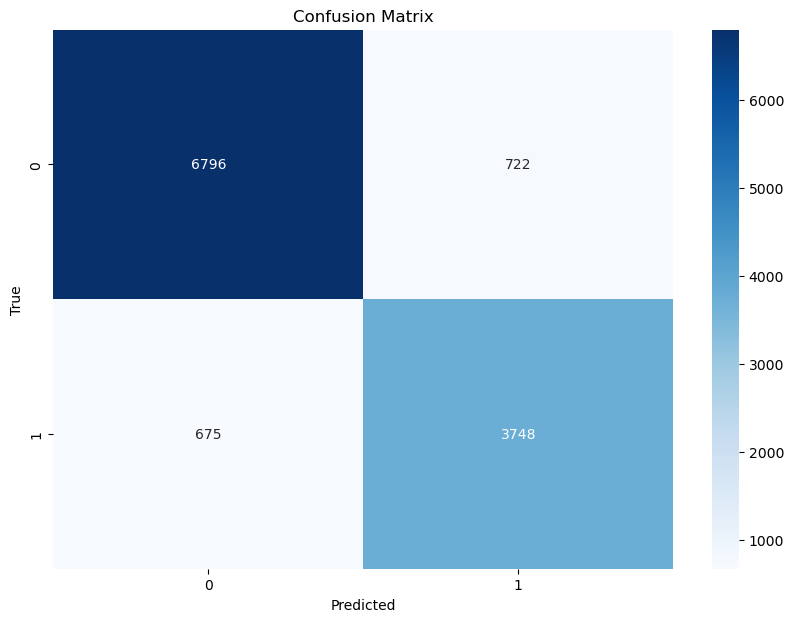

In [9]:
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC:

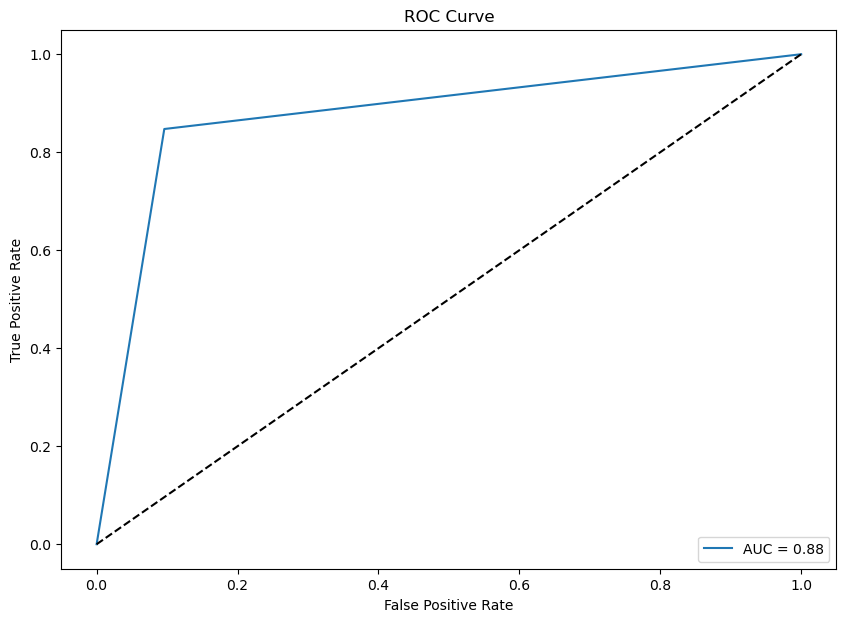

In [10]:
fpr, tpr, _ = roc_curve(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_preds)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve:

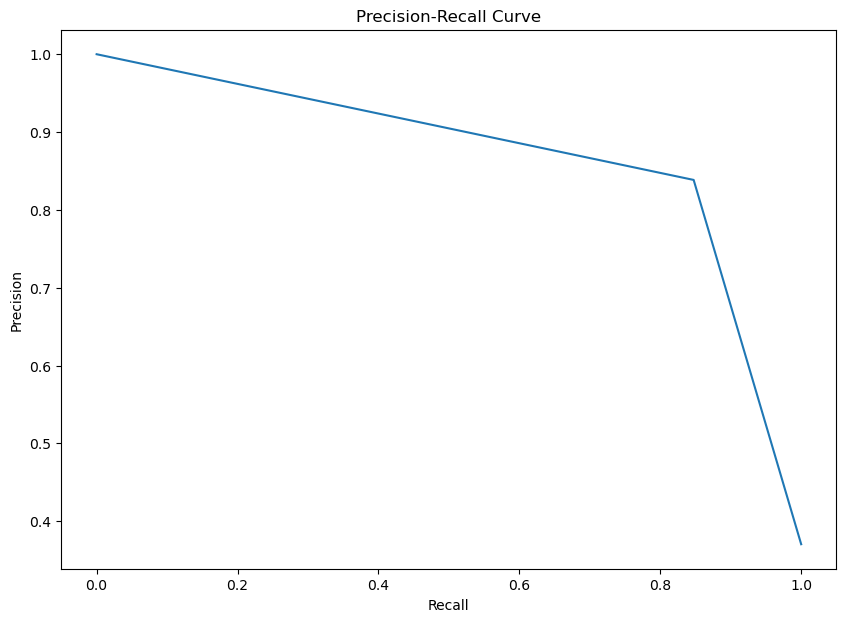

In [11]:
precision, recall, _ = precision_recall_curve(all_labels, all_preds)
plt.figure(figsize=(10, 7))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Feature Importance:

In [12]:
# Feature Importance (if applicable)
try:
    feature_importance = best_model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(10, 7))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance')
    plt.show()
except AttributeError:
    print("Feature importance is not available for this model.")

Feature importance is not available for this model.


# Learning Curves:

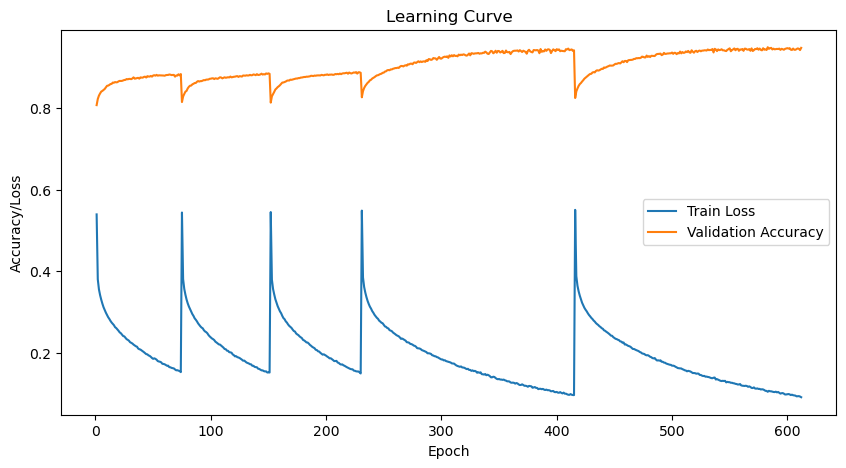

In [13]:
# Learning Curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()